# Important information from the paper:

Q-network is the function approximator, which is used to approximate the Q-function that maps the station-action pairs to their values.

To successfully train the Q-function, we want to minimize the following loss:

$$
L_i(\theta_i) = E_{s, a \sim \rho(\cdot)}\left[(y_i - Q(s, a; \theta_i))^2\right]
$$

Where $y_i$

$$
y_i = E_{s, a \sim \rho(\cdot); s'\sim \text{Env}}\left[\left(r + \gamma \max_{a'} Q(s', a'; \theta_{i-1}) - Q(s, a; \theta_i)\right) \nabla_{\theta_i} Q(s, a; \theta_i) \right]
$$


![Q-learning-algo.png](Q-learning-algo.png)

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def create_q_network(input_dim, n_layers, n_hidden, out_dim):
    dimensions = [input_dim] + n_layers * [n_hidden]

    layers = []
    for indim, outdim in zip(dimensions[:-1], dimensions[1:]):
        layers += [nn.Linear(indim, outdim), nn.ReLU()]
    layers += [nn.Linear(n_hidden, out_dim)]
    
    return nn.Sequential(*layers)

In [4]:
from collections import deque

class ReplayMemory:
    def __init__(self, max_len, batch_size=1):
        self.memory = deque([], maxlen=max_len)
        self.batch_size = batch_size
    def sample(self):
        batch_size = min(self.batch_size, len(self.memory))
        ids = np.random.randint(0, len(self.memory), size=batch_size)

        s0 = []
        a = []
        r = []
        s1 = []
        t = []
        
        for id in ids:
            s0.append(self.memory[id][0])
            a.append (self.memory[id][1])
            r.append (self.memory[id][2])
            s1.append(self.memory[id][3])
            t.append (self.memory[id][4])
        
        return torch.tensor(s0), torch.tensor(a), torch.tensor(r), torch.tensor(s1), torch.tensor(t)

    def add_memory(self, mem):
        self.memory.append(mem)

In [6]:
env = gym.make("ALE/MarioBros-v5")
obs, _ = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [7]:
N = 2000      # Memory buffer capacity
GAMMA = 0.999 # Discount rate
EPS = 1.0     # Epsilion for eps greedy

replay_memory = ReplayMemory(N, 32)

in_dim = len(obs)
n_layers = 3
n_hidden = 256
out_dim = env.action_space.n

# Initialize the model
model = create_q_network(in_dim, n_layers, n_hidden, out_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

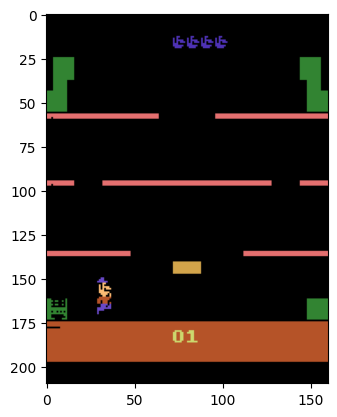

In [13]:
obs, _ = env.reset()
plt.imshow(obs)

In [8]:
def train_one_epoch(episodes):
    ep_rews = []
    global EPS
    eps = EPS
    
    for _ in range(episodes):
        obs, _ = env.reset()
        obs = torch.tensor(obs)
        
        ep_rew = 0
        done = False
        
        while not done:
            if np.random.random() < eps:
                act = env.action_space.sample()
            else:
                q = model(obs)
                act = q.argmax().item()
            
            new_obs, rew, term, trun, _ = env.step(act)
            new_obs = torch.tensor(new_obs)
            done = term or trun
            replay_memory.add_memory((obs.tolist(), act, rew, new_obs.tolist(), done))
            obs = new_obs
            
            s0, a, r, s1, t = replay_memory.sample()
        
            y_hat = model(s0)[range(len(s0)), a]
            y     = r + model(s1).max(dim=1).values * ~t
        
            optimizer.zero_grad()
            loss = ((y - y_hat)**2).mean()
            loss.backward()
            optimizer.step()
            
            ep_rew += rew
        
            eps = max(eps - 0.01, 0.1)
        
        ep_rews.append(ep_rew)
    
    return ep_rews

In [9]:
ep_rews = train_one_epoch(100)
plt.plot(ep_rews)
plt.show()
plt.hist(ep_rews, bins=20)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (33600x3 and 210x256)

In [36]:
env = gym.make("LunarLander-v2", render_mode='human')

for _ in range(5):
    done = False
    ep = 0
    obs, _ = env.reset()
    while not done:
        act = model(torch.tensor(obs)).argmax().item()
        obs, r, term, trun, _ = env.step(act)
        done = term or trun
        env.render()
        ep += r
    print(ep)
env.close()

61.999960069683766
21.165730686004935
275.5712503946148
294.51690655110485
-20.76503447709983


In [ ]:
ep_rews = []

for _ in range(200):
    done = False
    env.reset()
    ep = 0
    while not done:
        _, rew, done, _, _ = env.step(env.action_space.sample())
        ep += rew
    ep_rews.append(ep)

plt.plot(ep_rews)
plt.show()
plt.hist(ep_rews)